_Neural Data Science_

Lecturer: Prof. Dr. Philipp Berens

Tutors: Jonas Beck, Ziwei Huang

Summer term 2022

Student names: <span style='background: yellow'>*Moritz Kniebel, Vanessa Tsingunidis* </span>

# Coding Lab 1

Download the data file ```nda_ex_1.csv``` from ILIAS and save it in a subfolder ```../data/```.

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from scipy import signal
from sklearn.decomposition import PCA
from scipy.stats import median_abs_deviation
import scipy as sp
import itertools as it
sns.set_style('whitegrid')
%matplotlib inline

## Load data

In [2]:
fs = 30000     # sampling rate of the signal in Hz
dt = 1/fs
x = pd.read_csv('./data/nda_ex_1.csv', header=0, names=('Ch1', 'Ch2', 'Ch3', 'Ch4'))

In [3]:
x.describe()

,Ch1,Ch2,Ch3,Ch4
count,1.920000e+07,1.920000e+07,1.920000e+07,1.920000e+07
mean,3.600331e+00,-8.850918e-01,2.864284e-01,2.210982e+00
std,5.824474e+02,6.014818e+02,6.464363e+02,6.126105e+02
min,-3.607000e+03,-3.739000e+03,-3.871000e+03,-3.750000e+03
25%,-3.460000e+02,-3.610000e+02,-3.950000e+02,-3.640000e+02
50%,1.200000e+01,8.000000e+00,-1.000000e+00,1.000000e+01
75%,3.650000e+02,3.720000e+02,4.010000e+02,3.810000e+02
max,2.873000e+03,3.004000e+03,3.099000e+03,3.017000e+03


## Task 1: Filter Signal

In order to detect action potentials, the first step is to filter out low frequency fluctuations (LFP) and high frequency noise. Determine appropriate filter settings and implement the filtering in the function ```filter_signal()```. A typical choice for this task would be a <mark>butterworth filter</mark>. Plot a segment of the raw signal and the filtered signal for all four channels with matching y-axis. The segment you choose should contain spikes. When you apply the function also test different filter settings.

*Grading: 2 pts*


In [4]:
def filter_signal(x, fs, low, high, order=3):

    """Filter raw signal x. 
    
    Parameters
    ----------
    
    x: pd.DataFrame, (n_samples, 4)
        Each column in x is one recording channel.
    
    fs: int
        Sampling frequency.
    
    low, high: int, int
        Passband in Hz for the butterworth filter.   
        
    order: int
        The order of the Butterworth filter. Default is 3, but you should try 
        changing this and see how it affects the results.
        
    
    Return
    ------
    
    y: pd.DataFrame, (n_samples, 4)
        The filtered x. The filter delay is compensated in the output y.
        
    
    Notes
    ----
    
    1. Try exploring different filters and filter settings. More info:
    https://docs.scipy.org/doc/scipy/reference/generated/scipy.signal.butter.html
    
    2. The output signal should be phase-shift compensated. More info:
    https://dsp.stackexchange.com/a/19086
    
    """
    y = pd.DataFrame()
    nyquist = 0.5 * fs
    low = low / nyquist
    high = high / nyquist
    b, a = signal.butter(order, [low, high], btype='band')    
    for channel in x:
        y[channel] = signal.filtfilt(b, a, x[channel]) 

    # --------------------------------------------------------------------
    # implement a suitable filter and apply it to the input data (1.5 pts)
    # --------------------------------------------------------------------

 
    return y

In [5]:
xf = filter_signal(x, fs, 500, 4000)

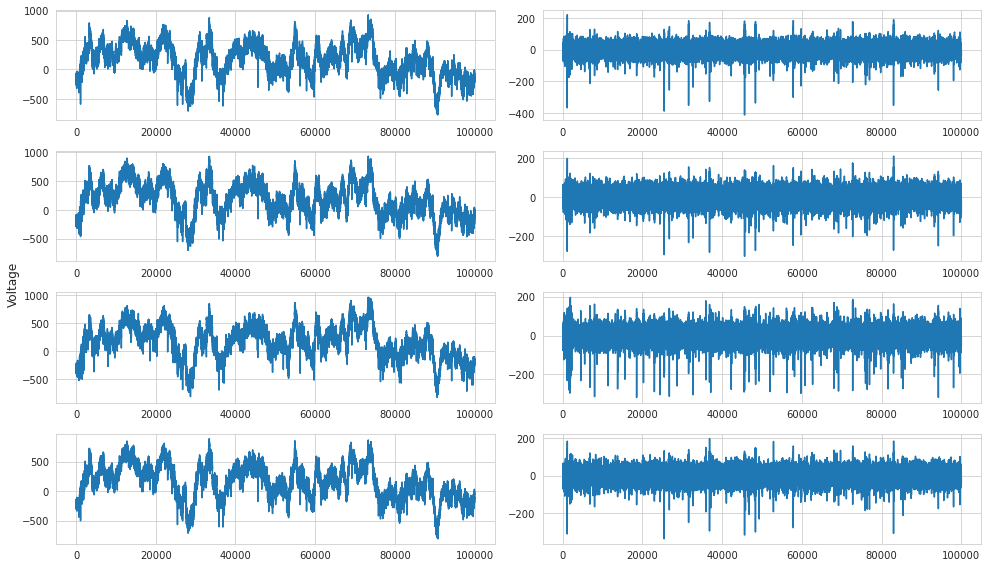

In [6]:
fig, ax = plt.subplots(4, 2, figsize=(14, 8))


ax[0, 0].plot(x['Ch1'][0:100000])
ax[0, 1].plot(xf['Ch1'][0:100000])
ax[1, 0].plot(x['Ch2'][0:100000])
ax[1, 1].plot(xf['Ch2'][0:100000])
ax[2, 0].plot(x['Ch3'][0:100000])
ax[2, 1].plot(xf['Ch3'][0:100000])
ax[3, 0].plot(x['Ch4'][0:100000])
ax[3, 1].plot(xf['Ch4'][0:100000])
fig.supylabel('Voltage')
#plt.ylabel('Voltage')
plt.tight_layout()
plt.show()

## Task 2: Detect action potentials

Action potentials are usually detected by finding large-amplitude deflections in the continuous signal. A good choice of threshold for detecting spikes is important. If it is too low, you will detect too many low amplitude events (noise); if it is too high, you run the risk of missing good spikes. Implement an automatic procedure to obtain a reasonable threshold and detect the times when spikes occurred in the function ```detect_spikes()``` . Plot a segment of the filtered signal for all four channels with matching y-axis and indicate the time points where you detected spikes. **Plot the threshold**. Are the detected time points well aligned with peaks in the signal?

*Grading: 3 pts*

In [7]:
def detect_spikes(x,fs, N=5, lockout=10):

    """Detect spikes, in this case, the relative local minima of the signal x.
    
    Parameters
    ----------
    
    x: pd.DataFrame
        The filtered signal from Task 1.
        
    fs: int
        the sampling rate (in Hz).
        
    N: int
        An arbitrary number with which you multiply with the standard deviation
        to set a threshold that controls your false positive rate. Default is 5
        but you should try changing it and see how it affects the results.
        
    lockout: int
        a window of 'refactory period', within which there's only one spike. 
        Default is 10 but you should also try changing it. 
    
    
    Returns
    -------
    
    s: np.array, (n_spikes,)
        Spike location / index in the singal x. 
    
    t: np.array, (n_spikes,)
        Spike time in ms. By convention the time of the zeroth sample is 0 ms.
    
    thrd: float
        Threshold = -Nσ. 
        
        
    Tips
    ----
    
    Use scipy functions to detect local minima. 
    Noted that there are four channels in signal x. 
        
    """
    s = []
    
    for channel in range(x.shape[1]):
    # ---------------------------------
    # compute the robust s.d. (0.5 pts)
    # ---------------------------------
        ch = x[:,channel]
        std = sp.stats.median_abs_deviation(ch - np.nanmean(ch))
        
    # ---------------------------------
    # calculate the threshold (0.5 pts)
    # ---------------------------------
        thrd = N*std
    
    # --------------------------------
    # find all local minima (1.5 pts)
    # --------------------------------
        minima, _ = signal.find_peaks(-ch, height=thrd, distance=lockout)
        s.append(minima)
    
    s = np.unique(np.concatenate(np.array(s, dtype=object)))
    t = (s/fs)*1000


    return (s, t), thrd

In [8]:
(s, t), threshold = detect_spikes(xf.values, fs, lockout=50)

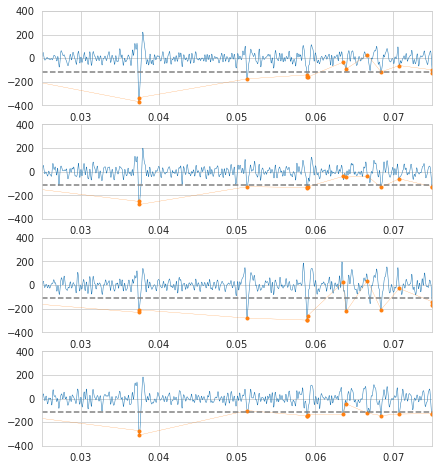

In [9]:
xf_ = xf.shape[0]

plt.figure(figsize=(7, 8))

scale_ch = np.arange(0,xf_)*dt

for i, channel in enumerate(xf):
    plt.subplot(4,1, i+1)
    plt.plot(scale_ch,xf[channel],linewidth=0.5)
    plt.plot(scale_ch[s], xf[channel][s], marker='.', linewidth=0.2)
    plt.axhline(y = -threshold, color = 'grey', linestyle = '--')
    plt.ylim((-400, 400))
    plt.xlim((0.025,0.075))

    
# --------------------------------------------
# plot threshold and detected spikes (0.5 pts)
# --------------------------------------------

plt.show()

## Task 3: Extract waveforms
For later spike sorting we need the waveforms of all detected spikes. Extract the waveforms segments (1 ms) on all four channels for each spike time (as a result each spike is represented by a 4x30 element matrix). Implement this procedure in the function ```extract_waveforms()```. Plot (a) the first 100 spikes you detected and (b) the 100 largest spikes you detected. Are there a lot of very small spikes (likely noise) among your detected spikes? If so your threshold may be too low. Can you see obvious artifacts, not looking like spikes at all?

*Grading: 2 pts*

In [10]:
def extract_waveforms(x, s):

    """Extract spike waveforms at times s (given in samples) 
    from the filtered signal `xf` using a fixed window around the 
    times of the spikes.
    
    Parameters
    ----------
    
    x: pd.DataFrame
        the filtered signal.
    
    s: np.array, (n_spikes, n_channels)
        Spike time in samples.
        
    
    Return
    ------
 
    w: np.array, (n_spikes, length_window, n_channels)
        Waveforms. # originally (length_window, n_spikes, n_channels)
        
    
    Notes
    -----
    
    More on Numpy Broadcasting
    https://jakevdp.github.io/PythonDataScienceHandbook/02.05-computation-on-arrays-broadcasting.html
    
    """

    #spike is represented by a 4x30 element matrix -> 4 channels and 30 window length 
    window_length = 30
    

    # 
    under_cut = int(window_length/3)
    upper_cut = under_cut*2
    
    
    #exclude incomplete samples
    s = s[np.where(s>under_cut)]
    s = s[np.where(s<(x.shape[0]-upper_cut))]
    
    n_spikes = len(s)
    
    #initialize w
    w = np.zeros([window_length, n_spikes, x.shape[1]])
    
    # extract waveform segments
    for channel in range(x.shape[1]):
        for i in range(n_spikes):
            spike = s[i]
            left = spike-under_cut 
            right = spike+upper_cut
            w[:,i,channel] = x[left:right,channel]
    return w
    

In [11]:
w = extract_waveforms(xf.values,s)

Plot first 100 spike waveforms

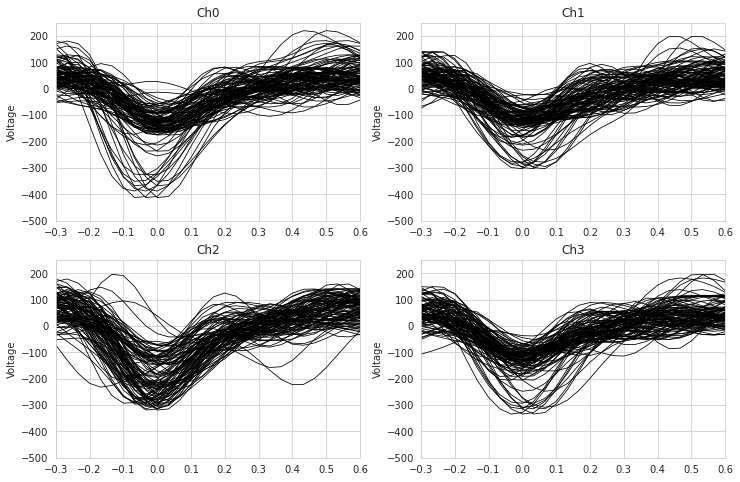

In [12]:
plt.figure(figsize=(12, 8))

for i, col in enumerate(xf):
    plt.subplot(2,2,i+1)
    plt.title('Ch{}'.format(i))
    plt.plot((np.arange(-10,20) * dt * 1000 ),w[:,1:100,i],'k', linewidth=0.8)
    plt.ylim((-500, 250))
    plt.xlim((-0.3,0.6))
    plt.ylabel('Voltage')

Plot largest 100 spike waveforms

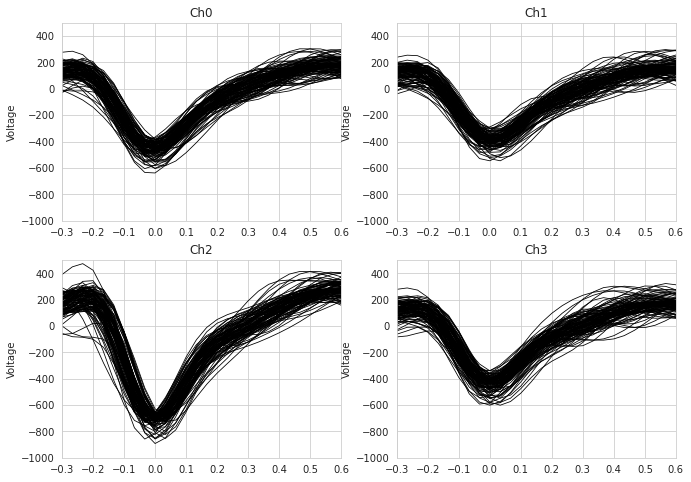

In [13]:
#find largest spikes
idx = np.argsort(np.min(np.min(w,axis=2),axis=0))

plt.figure(figsize=(11, 8))
for i, col in enumerate(xf):
    plt.subplot(2,2,i+1)
    plt.title('Ch{}'.format(i))
    plt.plot((np.arange(-10,20) * dt * 1000 ),w[:,idx[0:100],i],'k', linewidth=0.8)
    plt.ylim((-1000, 500))
    plt.xlim((-0.3,0.6))
    plt.ylabel('Voltage')

## Task 4: Extract features using PCA
Compute the first three PCA features on each channel separately in ```extract_features()``` (2 pts). You can use a available PCA implementation or implement it yourself. After that, each spike is represented by a 12 element vector. Compute the fraction of variance captured by these three PCs.
Plot scatter plots for all pairwise combinations of 1st PCs. Do you see clusters visually? 

*Grading: 2+1 pts*


Regarding preprocessing for PCA: 
https://stats.stackexchange.com/questions/385775/normalizing-vs-scaling-before-pca

Extract basic functions by using PCA, express variance with less data 

Why apply PCA here: 
Distinguish which waveform comes from which neuron by using clustering or in this case PCA

Gaussian is faster with more data 

In [14]:
def extract_features(w):

    """Extract features for spike sorting from the waveforms w.
    
    This implementation does PCA on the waveforms of each channel
    separately and uses the first three principal components. Thus, we get
    a total of 12 features.
    
    Parameter
    ---------
    
    w: np.array, (n_spikes, length_window, n_channels)
        Waveforms from Task 3.
    
    
    Return
    ------

    b: np.array, (n_spikes, n_feature)
        
        
    Notes
    -----
    
    You can use PCA from sklearn.

    More on PCA
    https://jakevdp.github.io/PythonDataScienceHandbook/05.09-principal-component-analysis.html

    """

    n_ch = w.shape[2]
    b = np.zeros((w.shape[1],3))
    for i in range(n_ch):
        ch=w[:,:,i].T
        pca=PCA(n_components=3)
        pca=pca.fit(ch)
        b_hat = pca.transform(ch)
        b = np.append(b,b_hat,axis=1)
    b = np.real(b[:,3:15]) 

    return b


In [15]:
b = extract_features(w)

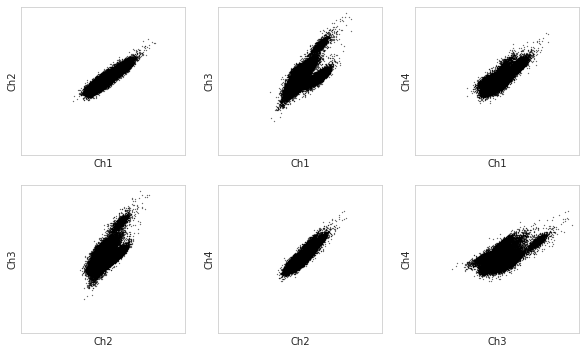

In [16]:
plt.figure(figsize=(10, 6))

idx = [0, 3, 6, 9]
cnt = 1
labels = ['Ch1','Ch2','Ch3','Ch4']
for i in np.arange(0,4):
    for j in np.arange(i+1,4):
        ax = plt.subplot(2,3,cnt)
        plt.plot(b[:,idx[i]],b[:,idx[j]],'.k', markersize=0.5) 
        plt.ylabel(labels[j])
        plt.xlabel(labels[i])
        plt.xlim((-2000,2000))
        plt.ylim((-2000,2000))
        ax.set_xticks([])
        ax.set_yticks([])
        cnt += 1

Every image shows the same signal but from a different angle/ from different channels

In [17]:
# np.save('../data/nda_ex_1_features',b)
# np.save('../data/nda_ex_1_spiketimes_s',s)
# np.save('../data/nda_ex_1_spiketimes_t',t)
# np.save('../data/nda_ex_1_waveforms',w)